In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [51]:
f = np.load('/Users/abdussamad/Documents/Github repos/portfolio-manager/BackTest/inputs.npz')

In [26]:
f.files

['arr_0', 'arr_1']

In [52]:
Xs, ys = f['arr_0'], f['arr_1']

In [33]:
Xs[:, 0, 1].reshape(-1, 1, 1)

array([[[16.30069273]],

       [[ 0.98756392]],

       [[23.47888866]],

       ...,

       [[18.26986162]],

       [[18.37410711]],

       [[ 2.116667  ]]])

In [53]:
scales = Xs[:, 0, 1].reshape(-1, 1, 1)
Xs[:, :, [5]] /= scales
Xs[:, :, :4] /= scales

In [29]:
Xs.shape

(452372, 15, 5)

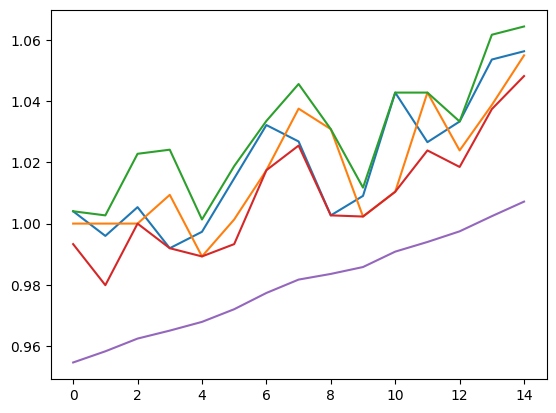

In [59]:
for i in range(4):
    plt.plot(Xs[399950, :, i])
plt.plot(Xs[399950, :, 5])    

In [83]:
def bresenham(img, x0, y0, x1, y1):
    dx = abs(x1 - x0)
    sx = 1 if x0 < x1 else -1 
    dy = -abs(y1 - y0)
    sy = 1 if y0 < y1 else -1
    error = dx + dy

    while True:
        img[x0, y0] = 255
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * error
        if e2 >= dy:
            if x0 == x1:
                break 
            error += dy
            x0 += sx
        if e2 <= dx:
            if y0 == y1:
                break
            error += dx
            y0 += sy

def make_image(sample, ema=True):
    height_bars = 96
    width = sample.shape[0] * 3
    img = np.zeros((width, height_bars), dtype=np.uint8)

    max_price = max(sample[:, :4].max(), sample[:, 5].max())
    min_price = min(sample[:, :4].min(), sample[:, 5].min())
    height_scaler = height_bars / (max_price - min_price)

    ema_y_prev = None

    for t in range(sample.shape[0]):
        open_y = round((sample[t, 1] - min_price) * height_scaler)
        img[3*t, open_y] = 255
        close_y = round((sample[t, 0] - min_price) * height_scaler)
        img[3*t+2, close_y] = 255

        low_y = round((sample[t, 3] - min_price) * height_scaler)
        high_y = round((sample[t, 2] - min_price) * height_scaler)
        img[3*t+1, low_y:high_y] = 255

        if ema:
            ema_y = round((sample[t, 5] - min_price) * height_scaler)
            img[3*t+1, ema_y] = 255
            if ema_y_prev is not None:
                bresenham(img, 3*t-2, ema_y_prev, 3*t+1, ema_y)
            ema_y_prev = ema_y

    
    return img.T



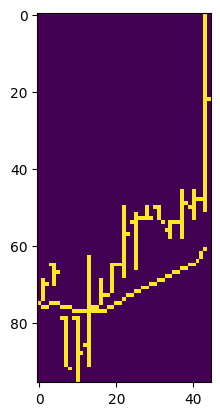

In [84]:
plt.imshow(make_image(Xs[1843]))

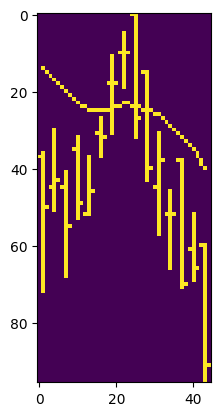

In [85]:
plt.imshow(make_image(Xs[18343]))

In [20]:
price_series = np.cumprod(Xs2 + 1, axis=-1)

In [9]:
Xs[:10]

array([[-0.00187236,  0.01313282,  0.00555563, -0.00506409,  0.02174886,
         0.        ,  0.00905817,  0.        , -0.01256736, -0.0181821 ,
         0.00925947,  0.00366944, -0.00182763,  0.00366266, -0.00729888],
       [ 0.02777786,  0.        , -0.02027008, -0.00689683,  0.        ,
         0.        , -0.00694473,  0.        ,  0.00699329, -0.02951379,
        -0.00536614,  0.00719345,  0.02500048, -0.0243907 , -0.0142863 ],
       [-0.0050378 ,  0.        , -0.00759476, -0.03571451,  0.04232839,
        -0.02030505,  0.0116581 ,  0.01152384,  0.01265867, -0.04625027,
        -0.00262104,  0.02496678, -0.00512796, -0.00896358, -0.01958174],
       [-0.00823103, -0.00414916, -0.01666682, -0.01694911,  0.01724133,
         0.00847497, -0.01470625, -0.00852813, -0.0064518 ,  0.02597373,
         0.01687738,  0.01659808, -0.03061215,  0.01052587, -0.0312495 ],
       [ 0.01388905,  0.04109589, -0.01315849,  0.0399998 , -0.0064099 ,
         0.        , -0.02580632, -0.00662282, 